## Introduction

In this notebook we will go through the basics of running and analysing `Cactus`/`Einstein Toolkit` data.
This will be a very basic introduction. For more details, see for instance the notes [An Introduction to the Einstein Toolkit](https://arxiv.org/abs/1305.5299).


## Notebook setup

In [1]:
# this allows you to use "cd" in cells to change directories instead of requiring "%cd"
%automagic on

# override IPython's default %%bash to not buffer all output
from IPython.core.magic import register_cell_magic

# use python strings within bash cells
@register_cell_magic
def bash(line, cell): get_ipython().system(cell)

import os
import scrolldown


Automagic is ON, % prefix IS NOT needed for line magics.


<IPython.core.display.Javascript object>

## Prerequisites

The very first step in running the Einstein Toolkit is obviously downloading and compiling it. The compiling stage is usually quite time-intensive, and sometimes requires some fiddling around (in particular on new clusters). So, in order to save time, for this workshop we're providing a Virtual Machine with an already compiled exectutable of the ET.

### Obtaining the Einstein Toolkit

This part will not be necessary for this session (it is already provided in the Virtual Machine), but just for reference, the procedure to obtain the ET is to follow the instructions here: <https://einsteintoolkit.org/download.html>.


#### kuibit

`kuibit` is a very useful analysis tool. It can be obtained via

```python
pip install --user -U kuibit==1.3.5 # requires Python3 version 3.6.1 or greater
```

### Building the Einstein Toolkit

This part will also not be necessary for this session (since an already compiled executable is provided in the Virtual Machine), but just for reference, the typical procedure to compile an ET executable without using `Simfactory` is as follows. First we create a *configuration*, which in this example (and in the provided VM) is called `ET`:

    cd Cactus
    make ET-config options=<machine config file> THORNLIST=<thornlist>

The machine configuration file needs to be prepared for each individual machine. Several examples of known machines (with extension `.cfg`) can be found in the folder `Cactus/simfactory/mdb/optionlists/`. For regular laptops, the `generic.cfg` file typically works well. The specific configuration file used for the executable provided in the VM (for a Fedora 36 operating system) is provided in the VM as well.
Once the configuration is done, the compilation process is simply

    make -j <number of processes> ET

After this, if everything is compiled correctly, an executable called `cactus_ET` will be created under the folder
`Cactus/exe/`. These steps need to be repeated for every different configuration (typically,
with different thornlists) built. As mentioned above, this is not needed for this session and you will find the executable `cactus_ET` already in the `Cactus/exe/` folder.

For convenience, let us store a variable with the path to this executable:

In [17]:
HOME = os.environ['HOME']
BASEDIR = os.path.join(HOME, "./ET/Cactus")
EXE = os.path.join(BASEDIR, "exe/cactus_ET"); EXE

'/home/meudon/./ET/Cactus/exe/cactus_ET'

## Running `Hello World`

To test the configuration, let us run the `HelloWorld` parameter file. The command for running the ET is similar to that of other MPI executables,

    mpirun -np <num procs> ./exe/cactus_ET <parameter file>

so for our particular case we do:

In [5]:
%%bash
export OMP_NUM_THREADS=1
mpirun -np 2 $EXE $BASEDIR/arrangements/CactusExamples/HelloWorld/par/HelloWorld.par

--------------------------------------------------------------------------------

       10                                  
  1   0101       ************************  
  01  1010 10      The Cactus Code V4.11.0    
 1010 1101 011      www.cactuscode.org     
  1001 100101    ************************  
    00010101                               
     100011     (c) Copyright The Authors  
      0100      GNU Licensed. No Warranty  
      0101                                 
--------------------------------------------------------------------------------

Cactus version:    4.11.0
Compile date:      Aug 01 2022 (10:36:07)
Run date:          Nov 14 2022 (16:18:55+0100)
Run host:          relayer (pid=16322)
Working directory: /home/mzilhao/01-Projectos/2022-11_Meudon/apr
Executable:        /home/mzilhao/./dev/ET/Cactus/exe/cactus_ET
Parameter file:    /home/mzilhao/./dev/ET/Cactus/arrangements/CactusExamples/HelloWorld/par/HelloWorld.par
------------------------------------------------

The above command will run the example "HelloWorld.par" and display its log output. If you see 

    INFO (HelloWorld): Hello World!

it has run correctly.

## Running the wave equation

Let us now run an example with the `WaveMoL` `thorn`

In [10]:
cwd = os.getcwd(); cwd

'/home/meudon/Documents/Belem2024'

first we create a simple parameter file under the folder "parfiles"

In [11]:
!mkdir parfiles
PARDIR = os.path.join(cwd,"parfiles")

In [13]:
cd $PARDIR

/home/meudon/Documents/Belem2024/parfiles


In [14]:
%%writefile gaussian-RK4.par
# gaussian-RK4.par
# Evolve the scalar wave equation with the RK4 integrator

ActiveThorns = "
   Boundary
   Carpet
   CarpetIOASCII
   CarpetIOBasic
   CarpetIOScalar
   CarpetLib
   CarpetReduce
   CartGrid3D
   CoordBase
   GenericFD
   IOUtil
   LoopControl
   ML_WaveToy
   MoL
   SymBase
   Time
"

Carpet::domain_from_coordbase = yes
CartGrid3D::type              = "coordbase"

CoordBase::domainsize = "minmax"
CoordBase::spacing    = "numcells"
CoordBase::xmin       = -15.0
CoordBase::ymin       = -5.0
CoordBase::zmin       = -5.0
CoordBase::xmax       = +5.0
CoordBase::ymax       = +5.0
CoordBase::zmax       = +5.0
CoordBase::ncells_x   = 100
CoordBase::ncells_y   = 50
CoordBase::ncells_z   = 50

CoordBase::boundary_size_x_lower = 2
CoordBase::boundary_size_y_lower = 2
CoordBase::boundary_size_z_lower = 2
CoordBase::boundary_size_x_upper = 2
CoordBase::boundary_size_y_upper = 2
CoordBase::boundary_size_z_upper = 2
Carpet::ghost_size               = 2

Cactus::cctk_itlast = 100

MoL::ODE_method             = "RK4"
MoL::MoL_Intermediate_Steps = 4
MoL::MoL_Num_Scratch_Levels = 1

Time::dtfac = 0.5


ML_WaveToy::initial_data = "Gaussian"
ML_WaveToy::WT_u_bound   = "newrad"
ML_WaveToy::WT_rho_bound = "newrad"


IO::out_dir      = $parfile
#IO::out_fileinfo = "none"

IOBasic::outInfo_every = 1
IOBasic::outInfo_vars  = "ML_WaveToy::u"

IOScalar::outScalar_reductions = "norm1 norm2 minimum maximum norm_inf"
IOScalar::outScalar_every      = 1
IOScalar::outScalar_vars       = "ML_WaveToy::WT_u"

IOASCII::out1D_every = 1
IOASCII::out1D_vars  = "ML_WaveToy::WT_u ML_WaveToy::WT_rho ML_WaveToy::WT_eps"

CarpetIOASCII::compact_format = yes
CarpetIOASCII::output_ghost_points = no

Writing gaussian-RK4.par


first we create a simple parameter file under the folder "parfiles"

and now we can run it, just like the "Hello World" example

In [19]:
!mkdir ~/runs
RUNDIR = os.path.join(HOME,"runs")

In [21]:
cd $RUNDIR

/home/meudon/runs


In [22]:
%%bash
export OMP_NUM_THREADS=1
mpirun -np 2 $EXE $PARDIR/gaussian-RK4.par

--------------------------------------------------------------------------------

       10                                  
  1   0101       ************************  
  01  1010 10      The Cactus Code V4.12.0    
 1010 1101 011      www.cactuscode.org     
  1001 100101    ************************  
    00010101                               
     100011     (c) Copyright The Authors  
      0100      GNU Licensed. No Warranty  
      0101                                 
--------------------------------------------------------------------------------

Cactus version:    4.12.0
Compile date:      Nov 07 2022 (21:19:28)
Run date:          Jun 19 2024 (06:19:29+0200)
Run host:          atelier (pid=4608)
Working directory: /home/meudon/runs
Executable:        /home/meudon/./ET/Cactus/exe/cactus_ET
Parameter file:    /home/meudon/Documents/Belem2024/parfiles/gaussian-RK4.par
--------------------------------------------------------------------------------

Activating thorn Cactus...Suc

INFO (CycleClock): Calibrated CycleClock: 0.372021 ns per clock tick (2.68802 GHz)
INFO (Vectors): Using vector size 1 for architecture scalar (no vectorisation, 64-bit precision)
INFO (hwloc): library version 2.5.0, API version 0x20500
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 2D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 3D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR scalar I/O provided by CarpetIOScalar
---------------------------------

       50     5.000 |   -0.1265008    0.0508660
       51     5.100 |   -0.1249368    0.0500100
       52     5.200 |   -0.1220594    0.0491937
       53     5.300 |   -0.1192784    0.0484064
       54     5.400 |   -0.1169934    0.0476376
       55     5.500 |   -0.1156997    0.0468942
       56     5.600 |   -0.1152458    0.0461732
       57     5.700 |   -0.1169892    0.0454752
       58     5.800 |   -0.1229219    0.0447965
       59     5.900 |   -0.1283221    0.0441382
-----------------------------------------------
Iteration      Time |             ML_WAVETOY::u
                    |      minimum      maximum
-----------------------------------------------
       60     6.000 |   -0.1328251    0.0435041
       61     6.100 |   -0.1364733    0.0428822
       62     6.200 |   -0.1376141    0.0422788
       63     6.300 |   -0.1362589    0.0416944
       64     6.400 |   -0.1343881    0.0411243
       65     6.500 |   -0.1333202    0.0405713
       66     6.600 |   -0.1397765    0.

we should now have a folder called "gaussian-RK4" with the output

### Plotting the output

The output for this example consists of simple ascii files. The `rho` function (which maps to either u or v in the equations above), is shown in the next cell. The "d" is for diagonal.

In [23]:
!head -20 ./gaussian-RK4/u.x.asc

# 1D ASCII output created by CarpetIOASCII
# created on atelier by meudon on Jun 19 2024 at 06:19:29+0200
# parameter filename: "/home/meudon/Documents/Belem2024/parfiles/gaussian-RK4.par"
#
# u x (u)
#
# iteration 0   time 0
# time level 0
# refinement level 0   multigrid level 0   map 0   component 0
# column format: 1:it	2:ix 3:iy 4:iz	5:time	6:x 7:y 8:z	9:data
0	0 26 26	0	-15.2 0 0	6.76552417976953e-51
0	1 26 26	0	-15 0 0	1.38634329364117e-49
0	2 26 26	0	-14.8 0 0	2.72940725719039e-48
0	3 26 26	0	-14.6 0 0	5.16290482005661e-47
0	4 26 26	0	-14.4 0 0	9.38313827283089e-46
0	5 26 26	0	-14.2 0 0	1.63843921700689e-44
0	6 26 26	0	-14 0 0	2.74878500791021e-43
0	7 26 26	0	-13.8 0 0	4.43077231241295e-42
0	8 26 26	0	-13.6 0 0	6.86193047676146e-41
0	9 26 26	0	-13.4 0 0	1.0210368460894e-39


In [24]:
# Load the data using numpy
import os
import numpy as np
data = np.genfromtxt(os.path.join("gaussian-RK4","u.x.asc"))
print(data.shape)

(10403, 9)


In [25]:
# Load the timesteps from the output data
time_steps = np.unique(data[:,0])
print(time_steps)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.]


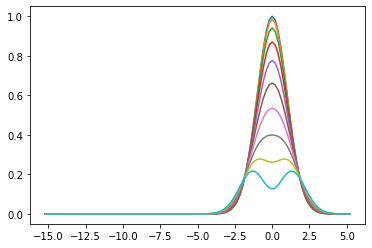

In [26]:
# Plot the first 10 timesteps
import matplotlib.pyplot as plt
x = data[data[:,0] == time_steps[0]][:,5]
for time_step in time_steps[:10]:
    step_data = data[data[:,0] == time_step][:,-1]
    plt.plot(x,step_data)

In [27]:
!mkdir figs

In [28]:
cd figs

/home/meudon/runs/figs


ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 12 (GCC)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --docdir=/usr/share/doc/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -flto=auto -ffat-lto-objects -fexceptions -g -grecord-gcc-switches -pipe -Wall -Werror=format-security -Wp,-D_FORTIFY_SOURCE=2 -Wp,-D_GLIBCXX_ASSERTIONS -specs=/usr/lib/rpm/redhat/redhat-hardened-cc1 -fstack-protector-strong -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1 -m64 -mtune=generic -fasynchronous-unwind-tables -fstack-clash-protection -fcf-protection' --extra-ldflags='-Wl,-z,relro -Wl,--as-needed -Wl,-z,now -specs=/usr/lib/rpm/redhat/redhat-hardened-ld -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1 -Wl,--build-id=sha1 -Wl,-dT,/builddir/build/BUILD/ffmpeg-5.0.1/.package_note-ffmpeg-5.0.1-12.fc36.x86_64.ld' --disable-htmlpages --enable-pic --disable-stripping --enable-shared --disab

0

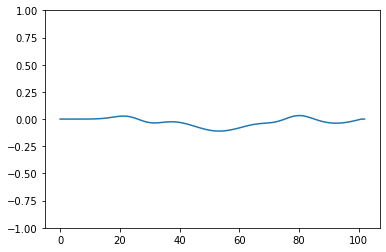

In [29]:
# Create a movie using all the timesteps
import matplotlib.pyplot as plt
frameno = 0
for time_step in time_steps:
    plt.clf()
    step_data = data[data[:,0] == time_step][:,-1]
    plt.ylim([-1,1])
    plt.plot(step_data)
    frameno += 1
    plt.savefig("plot%03d.png" % frameno)

from subprocess import call
call(["ffmpeg", "-i", "plot%03d.png", "-i", "plot001.png",
      "-filter_complex", "[1:v] palettegen [p];[0:v][p] paletteuse",
      "-y", "output.gif"])

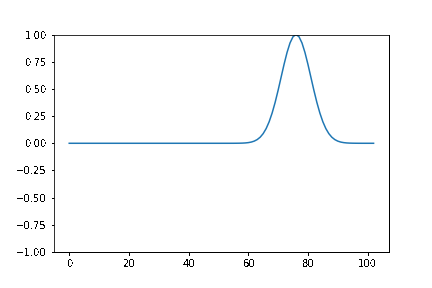

In [30]:
# Show the movie
from IPython.display import Image

Image("output.gif")

In [31]:
cd ..

/home/meudon/runs


### Exercises

- Change the parameters of the `WaveMoL` `thorn` and compare the output.
    - Recall that you can check the names of all the provided parameters in the file `WaveMoL/param.ccl`. All the parameters that are not explicitly set at runtime take the default values given therein.

In [32]:
cd $PARDIR

/home/meudon/Documents/Belem2024/parfiles


## TOV

Let us now simulate a static TOV star. Below we construct a Cactus parameter file to simulate a single, spherical symmetric star using the Einstein Toolkit.

In [33]:
%%writefile tov.par
# tov.par

# Example parameter file for a static TOV star. Everything is evolved, but
# because this is a solution to the GR and hydro equations, nothing changes
# much. What can be seen is the initial perturbation (due to numerical errors)
# ringing down (look at the density maximum), and later numerical errors
# governing the solution. Try higher resolutions to decrease this error.

# Some basic stuff
ActiveThorns = "Time MoL"
ActiveThorns = "Coordbase CartGrid3d Boundary StaticConformal"
ActiveThorns = "SymBase ADMBase TmunuBase HydroBase InitBase ADMCoupling ADMMacros"
ActiveThorns = "IOUtil"
ActiveThorns = "SpaceMask CoordGauge Constants LocalReduce aeilocalinterp LoopControl"
ActiveThorns = "Carpet CarpetLib CarpetReduce CarpetRegrid2 CarpetInterp"
ActiveThorns = "CarpetIOASCII CarpetIOScalar CarpetIOHDF5 CarpetIOBasic"

# Finalize
Cactus::terminate           = "time"
Cactus::cctk_final_time     = 80 #400 # divide by ~203 to get ms

# Termination Trigger
ActiveThorns = "TerminationTrigger"
TerminationTrigger::max_walltime = 24          # hours
TerminationTrigger::on_remaining_walltime = 0  # minutes
TerminationTrigger::check_file_every = 512
TerminationTrigger::termination_file = "TerminationTrigger.txt"
TerminationTrigger::termination_from_file   = "yes"
TerminationTrigger::create_termination_file = "yes"

# grid parameters
Carpet::domain_from_coordbase = "yes"
CartGrid3D::type         = "coordbase"
CartGrid3D::domain       = "full"
CartGrid3D::avoid_origin = "no"
CoordBase::xmin =  0.0
CoordBase::ymin =  0.0
CoordBase::zmin =  0.0
CoordBase::xmax = 24.0
CoordBase::ymax = 24.0
CoordBase::zmax = 24.0
# Change these parameters to change resolution. The ?max settings above
# have to be multiples of these. 'dx' is the size of one cell in x-direction.
# Making this smaller means using higher resolution, because more points will
# be used to cover the same space.
CoordBase::dx   =   2.0
CoordBase::dy   =   2.0
CoordBase::dz   =   2.0

CarpetRegrid2::regrid_every =   0
CarpetRegrid2::num_centres  =   1
CarpetRegrid2::num_levels_1 =   2
CarpetRegrid2::radius_1[1]  = 12.0


CoordBase::boundary_size_x_lower        = 3
CoordBase::boundary_size_y_lower        = 3
CoordBase::boundary_size_z_lower        = 3
CoordBase::boundary_size_x_upper        = 3
CoordBase::boundary_size_y_upper        = 3
CoordBase::boundary_size_z_upper        = 3
CoordBase::boundary_shiftout_x_lower    = 1
CoordBase::boundary_shiftout_y_lower    = 1
CoordBase::boundary_shiftout_z_lower    = 1
CoordBase::boundary_shiftout_x_upper    = 0
CoordBase::boundary_shiftout_y_upper    = 0
CoordBase::boundary_shiftout_z_upper    = 0


ActiveThorns = "ReflectionSymmetry"

ReflectionSymmetry::reflection_x = "yes"
ReflectionSymmetry::reflection_y = "yes"
ReflectionSymmetry::reflection_z = "yes"
ReflectionSymmetry::avoid_origin_x = "no"
ReflectionSymmetry::avoid_origin_y = "no"
ReflectionSymmetry::avoid_origin_z = "no"

# storage and coupling
TmunuBase::stress_energy_storage = yes
TmunuBase::stress_energy_at_RHS  = yes
TmunuBase::timelevels            =  1
TmunuBase::prolongation_type     = none
        


HydroBase::timelevels            = 3

ADMMacros::spatial_order = 4

SpaceMask::use_mask      = "yes"

Carpet::enable_all_storage       = no
Carpet::use_buffer_zones         = "yes"

Carpet::poison_new_timelevels    = "yes"
Carpet::check_for_poison         = "no"

Carpet::init_3_timelevels        = no
Carpet::init_fill_timelevels     = "yes"

CarpetLib::poison_new_memory = "yes"
CarpetLib::poison_value      = 114

# system specific Carpet paramters
Carpet::max_refinement_levels    = 10
driver::ghost_size               = 3
Carpet::prolongation_order_space = 3
Carpet::prolongation_order_time  = 2

# Time integration
time::dtfac = 0.25

MoL::ODE_Method             = "rk4"
MoL::MoL_Intermediate_Steps = 4
MoL::MoL_Num_Scratch_Levels = 1

# check all physical variables for NaNs
#  This can save you computing time, so it's not a bad idea to do this
#  once in a whioe.
ActiveThorns = "NaNChecker"
NaNChecker::check_every = 16384
NaNChecker::action_if_found = "terminate" #"terminate", "just warn", "abort"
NaNChecker::check_vars = "ADMBase::metric ADMBase::lapse ADMBase::shift HydroBase::rho HydroBase::eps HydroBase::press HydroBase::vel"

# Hydro paramters

ActiveThorns = "EOS_Omni GRHydro"

HydroBase::evolution_method      = "GRHydro"

GRHydro::riemann_solver         = "Marquina"
GRHydro::GRHydro_eos_type       = "Polytype"
GRHydro::GRHydro_eos_table      = "2D_Polytrope"
GRHydro::recon_method           = "ppm"
GRHydro::GRHydro_stencil        = 3
GRHydro::bound                  = "none"
GRHydro::rho_abs_min            = 1.e-10
# Parameter controlling finite difference order of the Christoffel symbols in GRHydro
GRHydro::sources_spatial_order  = 4

# Curvature evolution parameters

ActiveThorns = "GenericFD NewRad"
ActiveThorns = "ML_BSSN ML_BSSN_Helper"
ADMBase::evolution_method        = "ML_BSSN"
ADMBase::lapse_evolution_method  = "ML_BSSN"
ADMBase::shift_evolution_method  = "ML_BSSN"
ADMBase::dtlapse_evolution_method= "ML_BSSN"
ADMBase::dtshift_evolution_method= "ML_BSSN"

ML_BSSN::timelevels = 3

ML_BSSN::harmonicN           = 1      # 1+log
ML_BSSN::harmonicF           = 2.0    # 1+log
ML_BSSN::evolveA             = 1
ML_BSSN::evolveB             = 1
# NOTE: The following parameters select geodesic slicing. This choice only enables you to evolve stationary spacetimes.
#       They will not allow you to simulate a collapsing TOV star.
ML_BSSN::ShiftGammaCoeff     = 0.0
ML_BSSN::AlphaDriver         = 0.0
ML_BSSN::BetaDriver          = 0.0
ML_BSSN::advectLapse         = 0
ML_BSSN::advectShift         = 0
ML_BSSN::MinimumLapse        = 1.0e-8

ML_BSSN::my_initial_boundary_condition = "extrapolate-gammas"

ML_BSSN::my_rhs_boundary_condition     = "NewRad"

# Some dissipation to get rid of high-frequency noise
ActiveThorns = "SphericalSurface Dissipation"
Dissipation::verbose   = "no"
Dissipation::epsdis   = 0.01
Dissipation::vars = "
        ML_BSSN::ML_log_confac
        ML_BSSN::ML_metric
        ML_BSSN::ML_curv
        ML_BSSN::ML_trace_curv
        ML_BSSN::ML_Gamma
        ML_BSSN::ML_lapse
        ML_BSSN::ML_shift
"


# init parameters
InitBase::initial_data_setup_method = "init_some_levels"

# Use TOV as initial data
ActiveThorns = "TOVSolver"

HydroBase::initial_hydro         = "tov"
ADMBase::initial_data            = "tov"
ADMBase::initial_lapse           = "tov"
ADMBase::initial_shift           = "tov"
ADMBase::initial_dtlapse         = "zero"
ADMBase::initial_dtshift         = "zero"

# Parameters for initial star
TOVSolver::TOV_Rho_Central[0] = 1.28e-3
TOVSolver::TOV_Gamma          = 2
TOVSolver::TOV_K              = 100

# Set equation of state for evolution
EOS_Omni::poly_gamma                   = 2
EOS_Omni::poly_k                       = 100
EOS_Omni::gl_gamma                     = 2
EOS_Omni::gl_k                         = 100


# I/O

# Use (create if necessary) an output directory named like the
# parameter file (minus the .par)
IO::out_dir             = ${parfile}

# Write one file overall per output (variable/group)
# In production runs, comment this or set to "proc" to get one file
# per MPI process
IO::out_mode            = "onefile"

# Some screen output
IOBasic::outInfo_every = 512
IOBasic::outInfo_vars  = "Carpet::physical_time_per_hour HydroBase::rho{reductions='maximum'}"

# Scalar output
IOScalar::outScalar_every    = 512
IOScalar::one_file_per_group = "yes"
IOScalar::outScalar_reductions = "norm1 norm2 norm_inf sum maximum minimum"
IOScalar::outScalar_vars     = "
 HydroBase::rho{reductions='maximum'}
 HydroBase::press{reductions='maximum'}
 HydroBase::eps{reductions='minimum maximum'}
 HydroBase::vel{reductions='minimum maximum'}
 HydroBase::w_lorentz{reductions='minimum maximum'}
 ADMBase::lapse{reductions='minimum maximum'}
 ADMBase::shift{reductions='minimum maximum'}
 ML_BSSN::ML_Ham{reductions='norm1 norm2 maximum minimum norm_inf'}
 ML_BSSN::ML_mom{reductions='norm1 norm2 maximum minimum norm_inf'}
 GRHydro::dens{reductions='minimum maximum sum'}
 Carpet::timing{reductions='average'}
"

# 1D ASCII output. Disable for production runs!
IOASCII::out1D_every        = 2048
IOASCII::one_file_per_group = yes
IOASCII::output_symmetry_points = no
IOASCII::out1D_vars         = "
 HydroBase::rho
 HydroBase::press
 HydroBase::eps
 HydroBase::vel
 ADMBase::lapse
 ADMBase::metric
 ADMBase::curv
 ML_BSSN::ML_Ham
 ML_BSSN::ML_mom
"

# 2D HDF5 output
CarpetIOHDF5::output_buffer_points = "no"

CarpetIOHDF5::out2D_every = 2048
CarpetIOHDF5::out2D_vars = "
 HydroBase::rho
 HydroBase::eps
 HydroBase::vel
 HydroBase::w_lorentz
 ADMBase::lapse
 ADMBase::shift
 ADMBase::metric
 ML_BSSN::ML_Ham
 ML_BSSN::ML_mom
 "

Writing tov.par


run the simulation

In [34]:
cd $RUNDIR

/home/meudon/runs


In [36]:
%%bash
export OMP_NUM_THREADS=1
mpirun -np 2 $EXE $PARDIR/tov.par

--------------------------------------------------------------------------------

       10                                  
  1   0101       ************************  
  01  1010 10      The Cactus Code V4.12.0    
 1010 1101 011      www.cactuscode.org     
  1001 100101    ************************  
    00010101                               
     100011     (c) Copyright The Authors  
      0100      GNU Licensed. No Warranty  
      0101                                 
--------------------------------------------------------------------------------

Cactus version:    4.12.0
Compile date:      Nov 07 2022 (21:19:28)
Run date:          Jun 19 2024 (06:22:01+0200)
Run host:          atelier (pid=4724)
Working directory: /home/meudon/runs
Executable:        /home/meudon/./ET/Cactus/exe/cactus_ET
Parameter file:    /home/meudon/Documents/Belem2024/parfiles/tov.par
--------------------------------------------------------------------------------

Activating thorn Cactus...Success -> a

            GRHydro::GRHydro_SelectAtmosphereMaskBoundaries: [level] Select atmosphere mask for boundary conditions
            GROUP GRHydro_ApplyAtmosphereMaskBCs: Apply boundary conditions to real-valued atmosphere mask
              GROUP BoundaryConditions: Execute all boundary conditions
                Boundary::Boundary_ApplyPhysicalBCs: Apply all requested local physical boundary conditions
                CartGrid3D::CartGrid3D_ApplyBC: Apply symmetry boundary conditions
                ReflectionSymmetry::ReflectionSymmetry_Apply: Apply reflection symmetries
              Boundary::Boundary_ClearSelection: [level] Unselect all grid variables for boundary conditions
          GRHydro::GRHydroPostSyncAtmosphereMask: Set integer atmosphere mask from synchronized real atmosphere mask
          if (GRHydro::InLastMoLPostStep)
            GRHydro::GRHydro_AtmosphereReset: Reset the atmosphere
          GROUP HydroBase_Boundaries: HydroBase-internal Boundary conditions group
      

INFO (CycleClock): Calibrated CycleClock: 0.372018 ns per clock tick (2.68804 GHz)
INFO (Vectors): Using vector size 1 for architecture scalar (no vectorisation, 64-bit precision)
INFO (hwloc): library version 2.5.0, API version 0x20500
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
HydroBase: Let it flow.
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 2D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 3D ASCII I/O provided by CarpetIOASCII
---------------------------------------------------

INFO (CartGrid3D): Grid Spacings:
INFO (CartGrid3D): dx=>2.0000000e+00  dy=>2.0000000e+00  dz=>2.0000000e+00
INFO (CartGrid3D): Computational Coordinates:
INFO (CartGrid3D): x=>[-6.000,28.000]  y=>[-6.000,28.000]  z=>[-6.000,28.000]
INFO (CartGrid3D): Indices of Physical Coordinates:
INFO (CartGrid3D): x=>[0,17]  y=>[0,17]  z=>[0,17]
INFO (TerminationTrigger): Reminding you every 60 minutes about remaining walltime
INFO (Time): Timestep set to 0.5 (courant_static)
INFO (GRHydro): Trying to get EOS handles
INFO (GRHydro): Trying to get EOS handles
INFO (GRHydro): GRHydro will use the 2D_Polytrope equation of state.
INFO (GRHydro): Setting up the atmosphere mask: all points are not_atmosphere
INFO (TOVSolver): Integrated TOV equation
INFO (TOVSolver): Information about the TOVs used:
INFO (): TOV    radius    mass  bary_mass mass(g) cent.rho rho(cgi)        K   K(cgi)    Gamma
INFO ():   1   8.12502  1.40016  1.50618 2.78e+33  0.00128 7.92e+14      100 1.45e+05        2
INFO (TOVSolver):

    57856    56.500 | 3.443078e+03 |    0.0012369
    58368    57.000 | 3.436020e+03 |    0.0012372
    58880    57.500 | 3.430589e+03 |    0.0012375
    59392    58.000 | 3.425639e+03 |    0.0012378
    59904    58.500 | 3.422484e+03 |    0.0012381
    60416    59.000 | 3.425575e+03 |    0.0012385
    60928    59.500 | 3.427816e+03 |    0.0012388
-------------------------------------------------
Iteration      Time | *me_per_hour | *ROBASE::rho
                    |              |      maximum
-------------------------------------------------
    61440    60.000 | 3.419935e+03 |    0.0012391
    61952    60.500 | 3.416935e+03 |    0.0012395
    62464    61.000 | 3.419272e+03 |    0.0012398
    62976    61.500 | 3.423244e+03 |    0.0012402
    63488    62.000 | 3.423856e+03 |    0.0012405
    64000    62.500 | 3.424514e+03 |    0.0012409
    64512    63.000 | 3.427929e+03 |    0.0012413
    65024    63.500 | 3.432243e+03 |    0.0012416
    65536    64.000 | 3.431980e+03 |    0.0012420


### Plotting the output

This time let us use [kuibit](https://sbozzolo.github.io/kuibit/) to analyse and plot the data.

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit.simdir import SimDir
from kuibit.grid_data import UniformGrid

%matplotlib inline

let's start by looking at the available data

In [38]:
sim = SimDir("./tov")
gf  = sim.gf

print(gf)


Available grid data of dimension 1D (x): 
['gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'alp', 'rho', 'press', 'eps', 'vel[0]', 'vel[1]', 'vel[2]', 'H', 'M1', 'M2', 'M3']


Available grid data of dimension 1D (y): 
['gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'alp', 'rho', 'press', 'eps', 'vel[0]', 'vel[1]', 'vel[2]', 'H', 'M1', 'M2', 'M3']


Available grid data of dimension 1D (z): 
['gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'alp', 'rho', 'press', 'eps', 'vel[0]', 'vel[1]', 'vel[2]', 'H', 'M1', 'M2', 'M3']


Available grid data of dimension 2D (xy): 
['gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'alp', 'betax', 'betay', 'betaz', 'rho', 'eps', 'vel[0]', 'vel[1]', 'vel[2]', 'w_lorentz', 'H', 'M1', 'M2', 'M3']


Available grid data of dimension 2D (xz): 
['gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'alp', 'betax', 'betay', 'betaz', 'rho', 'eps', 'vel[0]', 'vel[1]', 'vel[2]

and let's focus on those available in the $z=0$ plane

In [39]:
vars2D = gf.xy
print(vars2D)


Available grid data of dimension 2D (xy): 
['gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'alp', 'betax', 'betay', 'betaz', 'rho', 'eps', 'vel[0]', 'vel[1]', 'vel[2]', 'w_lorentz', 'H', 'M1', 'M2', 'M3']



let us work with the density `rho`

In [40]:
rho = vars2D.fields.rho

In [41]:
print(rho)

In [42]:
# iteration 0:
rho0 = rho[0]

# print available iterations
print(rho.iterations)

[0, 2048, 4096, 6144, 8192, 10240, 12288, 14336, 16384, 18432, 20480, 22528, 24576, 26624, 28672, 30720, 32768, 34816, 36864, 38912, 40960, 43008, 45056, 47104, 49152, 51200, 53248, 55296, 57344, 59392, 61440, 63488, 65536, 67584, 69632, 71680, 73728, 75776, 77824, 79872, 81920]


or the available times

In [43]:
print(rho.available_times)

[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 46.0, 48.0, 50.0, 52.0, 54.0, 56.0, 58.0, 60.0, 62.0, 64.0, 66.0, 68.0, 70.0, 72.0, 74.0, 76.0, 78.0, 80.0]


let's see what information the object `rho0` holds

In [44]:
print(rho0)

Available refinement levels (components):
0 (1)
1 (1)
Spacing at coarsest level (0): [2. 2.]
Spacing at finest level (1): [1. 1.]


In [45]:
type(rho0)

kuibit.grid_data.HierarchicalGridData

we see that it's of the type `HierarchicalGridData`, storing the data in all available Carpet refinement levels. For now let us focus on the data in the inner level:

In [46]:
rho0_1, = rho0[1]; print(rho0_1)

we can access the data at specific point

In [47]:
rho0_1[1,1]

0.001181378289441353

and plot the data

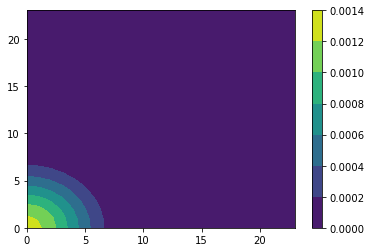

In [48]:
cf = plt.contourf(*rho0_1.coordinates_meshgrid(), rho0_1.data)

plt.colorbar(cf)

we can also analyse scalar reductions using kuibit's [TimeSeries](https://sbozzolo.github.io/kuibit/series.html#time-and-frequency-series)

In [49]:
timeseries = sim.ts
rho_max = timeseries.maximum['rho']

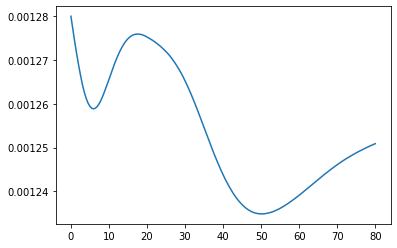

In [50]:
plt.plot(rho_max.t, rho_max.values)